In [152]:
"""
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


# constantes
PATH_HISTORIC = 'data/titanic_complete.csv'
USE_COLS = ['Age', 'Fare', 'Pclass', 'Sex', 'Survived'] # variaveis que usaremos no modelo
TEST_SIZE = 0.2
RANDOM_SEED = 42
N_SPLITS = 10

# leitura dos dados e insercao de uma feature sem correlacao com a label
df_titanic = pd.read_csv(PATH_HISTORIC, usecols=USE_COLS)
df_titanic.loc[:, 'id_rand_feature'] = np.arange(1, df_titanic.shape[0] + 1)

# separando entre features e labels
X = df_titanic.drop(columns='Survived')
y = df_titanic.loc[:, 'Survived']

# separando entre dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# pipeline colunas numericas
cols_num = ['Age', 'Fare']
imput_num = SimpleImputer(strategy='mean')
scaler_num = StandardScaler()
pipe_num = make_pipeline(imput_num, scaler_num)

# pipeline colunas categoricas
cols_cat = ['Sex']
imput_cat = SimpleImputer(strategy='most_frequent')
one_hot_cat = OneHotEncoder()
pipe_cat = make_pipeline(imput_cat, one_hot_cat)

# pipe par Pclass
cols_plcass = ['Pclass']
ordencod_pclass = OrdinalEncoder(categories=[['baixa', 'media', 'alta']])
pipe_pclass = make_pipeline(ordencod_pclass)

# column transformer
col_transf = ColumnTransformer([
                                ('Numerica', pipe_num, cols_num),
                                ('Categorica', pipe_cat, cols_cat),
                                ('Pclass', pipe_pclass, cols_plcass)], remainder='passthrough')

# instanciando modelos, transformadores e kfold
rand_forest = RandomForestClassifier(random_state=RANDOM_SEED)
grad_boost = GradientBoostingClassifier(random_state=RANDOM_SEED)
log_reg = LogisticRegression(random_state=RANDOM_SEED, solver='liblinear')

# instanciando o pipelline
pipe = make_pipeline(col_transf, rand_forest)

# treinando e avaliando nos dados de teste
pipe.fit(X_train, y_train)

# avaliacao nos de treino e teste
print(f'Acc treino: {pipe.score(X_train, y_train)*100:.2f}%')
print(f'Acc teste : {pipe.score(X_test, y_test)*100:.2f}%')

Acc treino: 100.00%
Acc teste : 79.89%


In [153]:
ohe_fet_names = list(pipe.named_steps['columntransformer'].named_transformers_['Categorica'].named_steps['onehotencoder'].get_feature_names(input_features=cols_cat))
feat_names = cols_num + ohe_fet_names + cols_plcass + ['id_rand_feature']
feat_impor_features = pipe.named_steps['randomforestclassifier'].feature_importances_

In [154]:
df_feat_import = pd.DataFrame({'Feat_Import': feat_impor_features, 'Feat_Names': feat_names}).sort_values(by='Feat_Import', ascending=False)

In [155]:
df_feat_import

,Feat_Import,Feat_Names
5,0.223132,id_rand_feature
1,0.221886,Fare
0,0.190270,Age
3,0.163732,Sex_male
2,0.114794,Sex_female
4,0.086186,Pclass


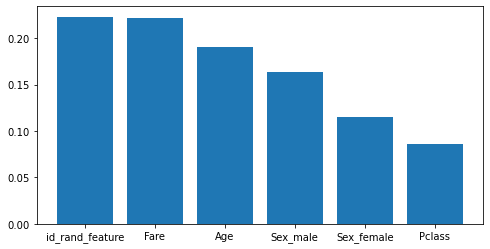

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(df_feat_import.Feat_Names, df_feat_import.Feat_Import)
plt.show()